<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Assessing the Impact of the 2024 Rio Grande do Sul Floods Using Earth Mosaics
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #floods, #waterindex

**Authors**: EarthDaily Analytics

**Last update:** 2024-11-07 (Created: 2024-11-05)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)
- [Xarray as multi-dimensional object](https://docs.xarray.dev/en/stable/)
- [Spyndex spectral indices library](https://github.com/awesome-spectral-indices/spyndex)

## Introduction
The [2024 Rio Grande do Sul floods](https://en.wikipedia.org/wiki/2024_Rio_Grande_do_Sul_floods) were severe floods caused by heavy rains and storms that hit the Brazilian state of Rio Grande do Sul and the adjacent Uruguayan cities of Treinta y Tres, Paysandú, Cerro Largo, and Salto. From 29 April through to May, the floods resulted in 181 fatalities, widespread landslides, and a dam collapse. It is considered the country's worst flooding in over 80 years.

In this notebook, we aim to assess the extent of the flooding using satellite imagery mosaics and geospatial analysis techniques. By comparing pre- and post-flood mosaics, we can quantify the affected areas.

## Objectives

- **Data Acquisition**: Retrieve pre- and post-flood satellite imagery for the affected regions.
- **Visualization**: Generate maps and visualizations to illustrate the extent of the flooding.
- **Flood Extent Mapping**: Detect newly flooded areas by analyzing the difference in MNDWI between pre- and post-flood images.
- **Area Quantification**: Calculate the total area affected by the floods in hectares.
- **Data Export**: Save intermediate data as GeoTIFFs for visualization in GIS software such as QGIS.
- **Adaptability**: Provide a workflow that can be adapted for other events requiring pre- and post-state analysis, such as fires, deforestation, or urban development.

## Data Description

We utilize satellite imagery from the EarthDataStore, specifically the **AI-Ready Mosaics Collection**, generated using the [EarthDaily EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) service using Sentinel-2 imagery. The imagery includes the **GREEN**, **NIR0.8**, **RED**, and **SWIR1.6** bands, essential for computing Normalized Difference Vegetation Index (NDVI) and Modified Normalized Difference Water Index (MNDWI). The datasets are:

- **Pre-Flood Image**: Captured before the floods in April 2024.
- **Post-Flood Image**: Captured after the floods in May 2024.

These images allow us to perform a comparative analysis to identify changes in water bodies due to the flooding.

## Methodology

### Normalized Difference Vegetation Index (NDVI) and Modified Normalized Difference Water Index (MNDWI)

The [NDVI-MNDWI formula](https://link.springer.com/chapter/10.1007/978-3-662-45737-5_51) is used to enhance open water features while suppressing built-up land noise, vegetation, and soil. It is calculated using:

- **Green Band (560nm)**: Sensitive to green vegetation and water turbidity.
- **Near-Infrared Band (842nm)**: Sensitive to land surface, vegetation, and water.
- **Red (665nm)**: Sensitive to vegetation and land surface. 
- **Short-Wave Infrared Band (1610nm)**: Useful for differentiating between water and non-water features.

### Flood Detection Procedure

1. **Data Discovery and Image Loading**: Retreive pre- and post-flood satellite image metadata using the [`EarthDaily Python Client`](https://github.com/earthdaily/earthdaily-python-client/tree/main) and load using the [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) function.
2. **Index Calculation and Difference Computation**: Compute the NDVI-MNDWI for both images to highlight water bodies and calculate the difference between the post-flood and pre-flood NDVI-MNDWI images to identify new water areas caused by flooding.
3. **Thresholding, Polygon Creation, and Area Calculation**: Apply a threshold (e.g., the 90th percentile) to the difference image to create a binary mask of flooded areas, convert the binary mask to polygons using the [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes) function, and compute the area of each polygon to quantify the total affected area.

## Environment Setup

We start by setting up the environment and loading the necessary libraries, including [Dask](https://www.dask.org/) for parallel computing and geospatial libraries like [GeoPandas](https://geopandas.org/en/stable/docs/reference.html) and [Rasterio](https://rasterio.readthedocs.io/en/stable/).

We then:

- **Load Environment Variables**: Access API keys and other configurations.
- **Initialize the Dask Client**: Set up Dask for efficient data processing.
- **Authenticate and Initialize the Earth Data Store Client**: Connect to the data source for querying and retrieving satellite imagery.
- **Declare Global Variables**: Such as the input Collection, a list of Bands, output Resolution, Bounding Box to clip to, and the corresponding STAC Item IDs for the input EarthMosaic datasets.

### Import dependencies

In [2]:
from earthdaily import EDSClient, EDSConfig

In [3]:
import os

import dask.distributed
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import spyndex
import xarray as xr
from dotenv import load_dotenv
from odc.stac import configure_rio, stac_load
from rasterio.features import shapes
from shapely.geometry import shape

### Authentication
Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [4]:
load_dotenv("EDS.env", override=True)

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

Establishing a connection to the Earth Data Store:

In [5]:
eds = EDSClient(EDSConfig())

### Dask Client
Here we take advantage of the concurrent processing capabilities of the [Dask Distributed API](https://distributed.dask.org/en/stable/) for larger raster workloads:

In [6]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57610/status,
Dashboard: http://127.0.0.1:57610/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57611,Workers: 4
Dashboard: http://127.0.0.1:57610/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:57623,Total threads: 2
Dashboard: http://127.0.0.1:57628/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:57614,


### Declare Variables
Query parameters for the specific item, including STAC Collection and a list of bands:

In [7]:
COLLECTION = "ai-ready-mosaics-sample"
BANDS = ("green", "nir08", "red", "swir16")
RESOLUTION = 100.0

_**Note:** Since we are pulling the entire image for each Mosaic, we chose 100m for quicker computation on smaller machines. Choose 10 meters for full resolution but be prepared for longer processing times._

Dictionary to store item IDs for pre- and post-flood

In [8]:
item_dict = {
    "PRE": {"item_id": "EDA_Mosaic_M_L2A_EM_Mosaic_8YNF2"},  # PRE FLOOD
    "POST": {"item_id": "EDA_Mosaic_M_L2A_EM_Mosaic_F9QkJ"},  # POST FLOOD
}

_**Note:** The following function replaces each STAC Item's default href with an alternate presigned URL. This allows for access to the data directly without the need for an AWS account._

In [9]:
def replace_alternate_href(item):
    for asset in item.assets:
        alt_href = item.assets[asset].extra_fields["alternate"]["download"]["href"]
        item.assets[asset].href = alt_href
    return item

## Loading Satellite Data and Calculating Flooded Areas
Below we will iterate over each Item ID corresponding to a **PRE** and **POST** flood Mosaic. For each item we:

* Retrieve the corresponding EarthMosaic items, by passing a Collection and Item ID to an EarthDataStore search
* Use [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) to retrieve an [`xarray Dataset`](https://docs.xarray.dev/en/stable/), which includes: 
    - **Band Selection**: We focus on key spectral bands—green, near-infrared, red, and swir16—which are later used for calculating NDVI-MNDWI
    - **CRS and Resolution**: We reproject the data to `EPSG:3857` to work with a 100-meter spatial resolution.
* Calculate NDVI-MNDWI, which utilizes the [spyndex](https://spyndex.readthedocs.io/en/latest/) library for efficient calculation of spectral indices

_**Note**: Spyndex supports a wide range of indices. Feel free to experiment with other indices like the Augmented Normalized Difference Water Index (ANDWI) or the Land Surface Water Index (LSWI) to compare results._

### Spyndex Index Compute Utility
Defining a wrapper function for our NDVI-MNDWI calculation:

In [10]:
def calc_ndvimndwi(dataset):
    # Filtering out 0 values replacing with nan
    # result = xr.full_like(
    #     dataset, fill_value=np.nan
    # )
    # dataset = result.where(dataset == 0, dataset)
    for var in dataset.data_vars:
        dataset[var] = dataset[var].where(dataset[var] != 0)
    ndvimndwi = spyndex.computeIndex(
        index="MNDWI", G=dataset["green"], N=dataset["nir08"], R=dataset["red"], S1=dataset["swir16"]
    )

    dataset["ndvimndwi"] = ndvimndwi
    return dataset

In [11]:
for post_or_pre, data_dict in item_dict.items():
    print(f"Processing {post_or_pre}-flood imagery")
    # Search items
    item = list(
        eds.platform.pystac_client.search(
            collections=[COLLECTION],
            ids=[data_dict["item_id"]],
        ).items()
    )[0]

    item = replace_alternate_href(item)
    item_dict[post_or_pre]["item"] = item

    dataset = stac_load(
        [item],
        bands=BANDS,
        crs="epsg:3857",  # since resolution is in metres, we need to use a projected CRS
        resolution=RESOLUTION,
        chunks={"x": 2048, "y": 2048},  # here you could use Dask to lazy load the data
        groupby="id",
    )
    print("Returned dataset")
    dataset = calc_ndvimndwi(dataset)
    print("Calculated NDVIMNDWI")
    item_dict[post_or_pre]["dataset"] = dataset

Processing PRE-flood imagery
Returned dataset
Calculated NDVIMNDWI
Processing POST-flood imagery
Returned dataset
Calculated NDVIMNDWI


### Plot Output Imagery and Spectral Indices
Below, for each image we plot a false-color RGB composite **(SWIR,NIR,GREEN)** alongside the corresponding NDVI-MNDWI:

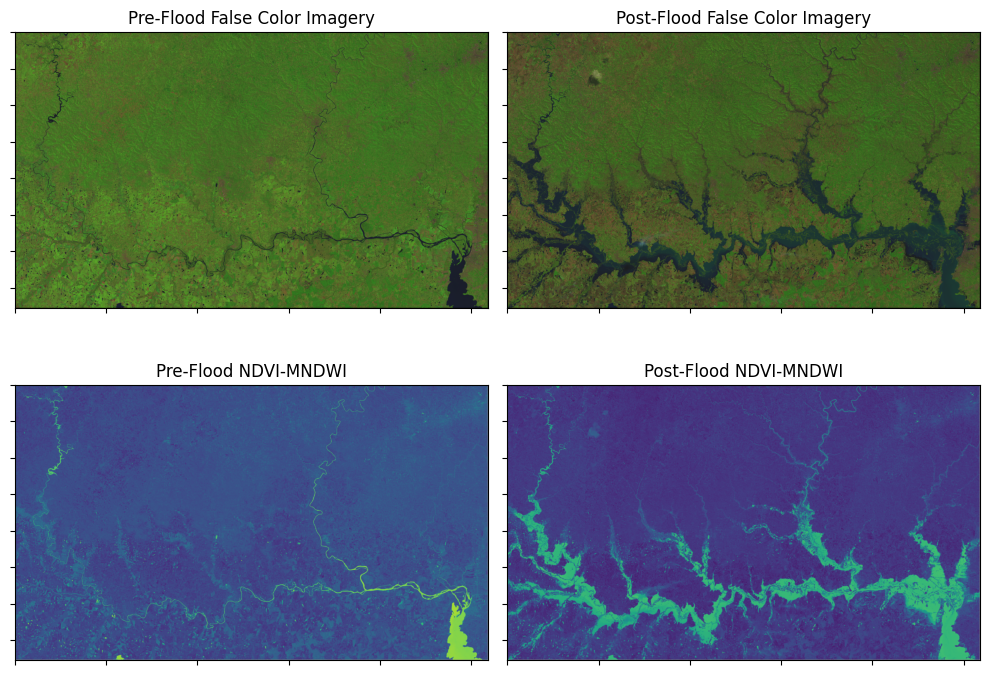

In [12]:
fig, ax = plt.subplots(figsize=(10, 7.5), nrows=2, ncols=2)

pre = item_dict["PRE"]["dataset"].isel(time=0)
post = item_dict["POST"]["dataset"].isel(time=0)

pre_arr = np.stack([pre["swir16"], pre["nir08"], pre["green"]], axis=-1)

post_arr = np.stack([post["swir16"], post["nir08"], post["green"]], axis=-1)

ax[0][0].imshow((np.nan_to_num((pre_arr / 10000) * 255)).astype("uint8"))
ax[0][0].set_title("Pre-Flood False Color Imagery")
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])

ax[0][1].imshow((np.nan_to_num((post_arr / 10000 * 255)).astype("uint8")))
ax[0][1].set_title("Post-Flood False Color Imagery")
ax[0][1].set_yticklabels([])
ax[0][1].set_xticklabels([])

ax[1][0].imshow(pre["ndvimndwi"])
ax[1][0].set_title("Pre-Flood NDVI-MNDWI")
ax[1][0].set_yticklabels([])
ax[1][0].set_xticklabels([])

ax[1][1].imshow(post["ndvimndwi"])
ax[1][1].set_title("Post-Flood NDVI-MNDWI")
ax[1][1].set_yticklabels([])
ax[1][1].set_xticklabels([])
plt.tight_layout()
del pre_arr, post_arr

## Calculate the Flooded Area

Analyzing the difference in NDVI-MNDWI values enables:

- **Change Detection**: Areas with substantial differences indicate potential flooded regions.
- **Quantification**: This allows us to estimate the extent of the area affected by the flood.

This comparative analysis is crucial for assessing the flood's impact on the landscape.

### Pre- and Post-Flood Index Comparison
First we subtract the PRE and POST flood water indices to calculate a difference:

In [13]:
diff = xr.concat(
    [item_dict["PRE"]["dataset"]["ndvimndwi"], item_dict["POST"]["dataset"]["ndvimndwi"]], dim="time"
).diff(dim="time")
diff

<xarray.DataArray 'ndvimndwi' (time: 1, y: 1510, x: 2590)> Size: 16MB
dask.array<sub, shape=(1, 1510, 2590), dtype=float32, chunksize=(1, 1510, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-05-06T13:40:32.830000
  * y            (y) float64 12kB -3.384e+06 -3.384e+06 ... -3.535e+06
  * x            (x) float64 21kB -5.95e+06 -5.95e+06 ... -5.691e+06 -5.691e+06
    spatial_ref  int32 4B 3857
Attributes:
    nodata:   0.0

### Plot Difference in Water Indices

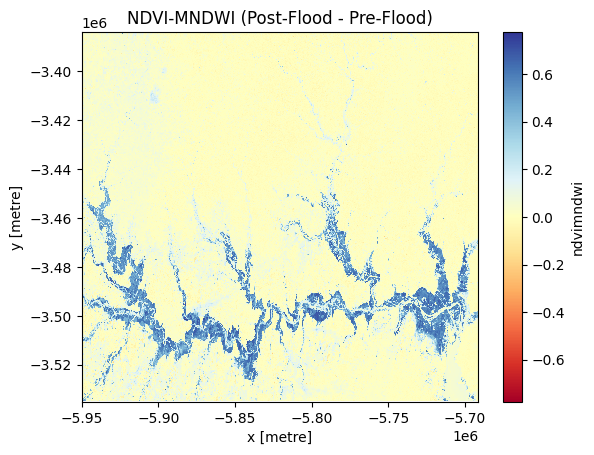

In [14]:
diff.plot(cmap="RdYlBu")
plt.title("NDVI-MNDWI (Post-Flood - Pre-Flood)")
plt.show()

### Exporting Data for GIS Visualization
To facilitate visualization and further spatial analysis:

- **GeoTIFF Export**: Save the xarray dataset as a GeoTIFF file.
- **GIS Compatibility**: The GeoTIFF can be imported into GIS software like QGIS, allowing for interactive exploration and overlay with other geospatial datasets.

By exporting the data, we bridge the gap between data processing and practical application in GIS platforms.

In [15]:
diff.rio.to_raster("NDVIMNDWI_diff.tif")

In [16]:
diff = rioxarray.open_rasterio("NDVIMNDWI_diff.tif")
diff

<xarray.DataArray (band: 1, y: 1510, x: 2590)> Size: 16MB
[3910900 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 12kB -3.384e+06 -3.384e+06 ... -3.535e+06
  * x            (x) float64 21kB -5.95e+06 -5.95e+06 ... -5.691e+06 -5.691e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ndvimndwi

### Extracting Flooded Area Polygons

To visualize and quantify the flooded areas:

- **Thresholding**: Apply a threshold to the NDVI-MNDWI difference image to isolate significant changes.
- **Polygon Generation**: Use the [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes) module to vectorize the boundaries of flooded regions.
- **Export to GeoJSON**: Save the polygons as a GeoJSON file for use in GIS applications.

This step transforms raster data into vector formats suitable for spatial analysis and mapping.

#### Threshold Selection

Choosing the right threshold is crucial for accurately identifying flooded areas.

In this cell, we explore different threshold values using [`np.nanpercentile`](https://numpy.org/doc/stable/reference/generated/numpy.nanpercentile.html) to retrieve the 90th and 95th percentile values for NDVI-MNDVI difference between pre- and post-flood. We then create a _binary mask_ array where 1=above the threshold and 0=below the threshold. Note that as the percentile decreses, more pixels are classified as flooded:

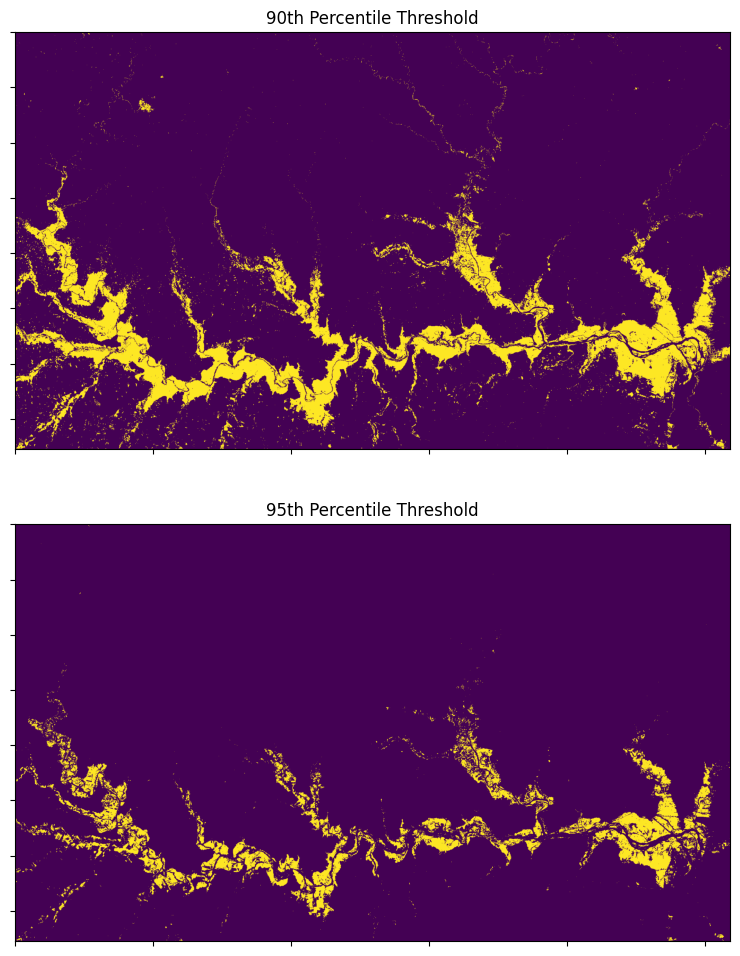

In [17]:
fig, ax = plt.subplots(figsize=(7.5, 10), nrows=2, ncols=1)
# Apply a threshold to identify significant differences
threshold_value_90 = np.nanpercentile(diff, 90)
threshold_value_95 = np.nanpercentile(diff, 95)

diff_msk_90 = (diff > threshold_value_90).astype("uint8")
diff_msk_95 = (diff > threshold_value_95).astype("uint8")

ax[0].imshow(diff_msk_90[0])
ax[0].set_title("90th Percentile Threshold")
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[1].imshow(diff_msk_95[0])
ax[1].set_title("95th Percentile Threshold")
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
plt.tight_layout()

#### Vectorization

Next we can vectorize our thresholded results to create a GeoDataFrame to summarize total flooded area. We use the 90th percentile of the difference image to focus on significant changes, but this value can be adjusted based on the analysis requirements.

In [18]:
polygons = list(shapes(diff_msk_90, mask=(diff_msk_90 == 1), transform=diff_msk_90.rio.transform()))

gdf = gpd.GeoDataFrame({"geometry": [shape(poly[0]) for poly in polygons]}, crs=diff_msk_90.rio.crs)
# 1m^2 == 0.0001 hectares
flooded_hectares = int((gdf.area * 0.0001).sum())

#### Plot Vector Results

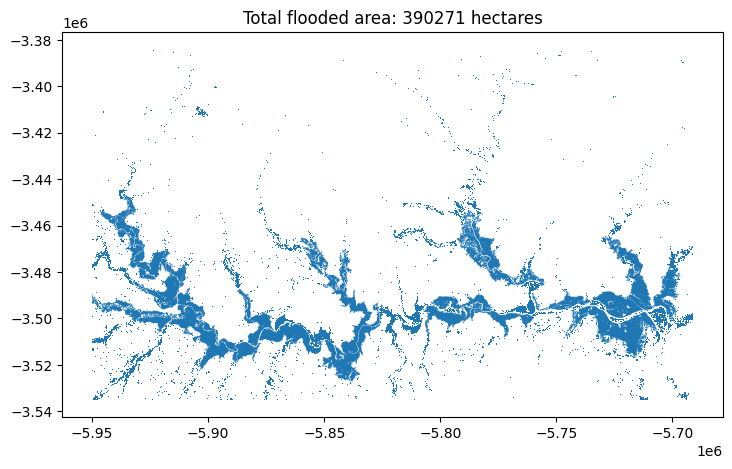

In [19]:
gdf.plot(figsize=(10, 5))
plt.title(f"Total flooded area: {flooded_hectares} hectares")
plt.show()

#### Export for GIS
Saving results for GIS environments:

In [20]:
gdf.to_file("flooded_area.geojson")

##  Results and Discussion

The analysis successfully identified and mapped the flooded areas in the Rio Grande do Sul region. By comparing the pre- and post-flood NDVI-MNDWI images, we detected significant changes in water bodies corresponding to the flood events.

- **Total Affected Area**: The floods affected an estimated area of **`390271` hectares** in this scene, corroborating reports of widespread flooding and damage.
- **Spatial Distribution**: The flooded areas are concentrated along riverbanks and low-lying regions, which are more susceptible to flooding during heavy rainfall.


### _Cleaning up:_

In [21]:
os.remove("NDVIMNDWI_diff.tif")
os.remove("flooded_area.geojson")